# Create necessary framework

## Create the necessary training data 

In [2]:
library(tidyverse)
library(car)
library(olsrr)
library(stringr)
library(tidytext)
library(syuzhet)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
Warning message:
“package ‘tibble’ was built under R version 3.4.4”Warning message:
“package ‘purrr’ was built under R version 3.4.4”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“package ‘car’ was built under R version 3.4.4”Loading required package: carData
Warning message:
“package ‘carData’ was built under R version 3.4.4”
Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some


Attaching package: ‘olsrr’

The following object is masked from ‘package:datasets’:

    rivers

Warning message:
“package ‘tidytext’ was built under R version 

In [3]:
# Make sure to change this
setwd("/home/yeachan153/Desktop/BDS/R/Big Data Analytics/Big-Data-Analytics/Text Analytics Project")

" 
Read in the CSV file
"
personality = as.tibble(read.csv("youtube-personality/YouTube-Personality-Personality_impression_scores_train.csv", 
                                 encoding = "UTF-8",
                                 sep = " "))

gender = as.tibble(read.csv("youtube-personality/YouTube-Personality-gender.csv",
                            encoding = "UTF-8",
                            sep = " "))

audiovisual = as.tibble(read.csv("youtube-personality/YouTube-Personality-audiovisual_features.csv",
                                 encoding = "UTF-8",
                                 sep = " "))

transcripts = as.tibble(read.csv("youtube-personality/transcripts.csv",
                                 encoding = "UTF-8",
                                 sep = ","))

transcripts$index = as.character(transcripts$index)

transcripts =
  transcripts %>%
  rename(vlogId = index,
         transcript = X0) %>%
  mutate(vlogId = substr(vlogId, 1, nchar(vlogId)-4))

personality$vlogId = as.character(personality$vlogId)
gender$vlogId = as.character(gender$vlogId)
audiovisual$vlogId = as.character(audiovisual$vlogId)

training_data = 
  personality %>%
  left_join(gender, on = c("vlogID" = "vlogID")) %>%
  left_join(audiovisual, on = c("vlogID" = "vlogID")) %>%
  left_join(transcripts, on = c("clogID" = "vlogID"))

#tokenization
training_data$transcript <- as.vector(training_data$transcript)
tidy_data <- training_data %>% 
  unnest_tokens(word, transcript, to_lower = TRUE) %>% 
  anti_join(get_stopwords())

#count the total number of words for each person
total_words <- tidy_data %>% 
  group_by(vlogId) %>% 
  count() %>% 
  rename(total_words = n)

#count the percentage of words related to big 5
words_E = c("bar","drinks", "restaurant", "dancing", "restaurants", "grandfather", "miami", "countless", "drinking", "shots", "girls", "glorious", "pool", "crowd", "sang", "grilled")
words_A = c("wonderful", "together", "visiting", "morning", "spring", "walked", "beautiful", "staying", "felt", "share", "gray", "joy", "afternoon", "day", "moments", "hug", "glad")
words_C = c("completed", "adventure", "adventures", "enjoying", "hawaii", "it's", "deck")
words_N = c("awful", "though", "lazy", "worse", "depressing", "irony", "terrible", "stressful", "horrible", "sort", "annoying", "ashamed", "ban")
words_O = c("folk", "humans", "of", "poet", "art", "by", "universe", "poetry", "narrative", "culture", "century", "sexual", "films", "novel", "decades", "ink", "passage", "literature", "blues")
words_nE = c("other", "cats", "computer", "minor")
words_nA = c("porn", "cost", "fuck")
words_nC = c("stupid", "boring", "desperate", "saying", "utter", "it's", "extreme")
words_nN = c("road", "southern", "visited", "ground", "oldest", "invited", "completed")
words_nO = c("giveaway")

check_words <- function(wordlist){
  tidy_data %>% 
    filter(word %in% wordlist) %>% 
    group_by(vlogId) %>% 
    count() %>% 
    left_join(total_words) %>% 
    mutate(n/total_words) %>% 
    select(-n, -total_words)
}

E_words <- check_words(words_E) %>% 
  rename(words_Extraversion = 'n/total_words')

A_words <- check_words(words_A) %>% 
  rename(words_Agreeableness = 'n/total_words')

C_words <- check_words(words_C) %>% 
  rename(words_Conscientiousness = 'n/total_words')

N_words <- check_words(words_N) %>% 
  rename(words_Neuroticism = 'n/total_words')

O_words <- check_words(words_O) %>% 
  rename(words_Openness = 'n/total_words')

nE_words <- check_words(words_nE) %>% 
  rename(words_nExtraversion = 'n/total_words')

nA_words <- check_words(words_nA) %>% 
  rename(words_nAgreeableness = 'n/total_words')

nC_words <- check_words(words_nC) %>% 
  rename(words_nConscientiousness = 'n/total_words')

nN_words <- check_words(words_nN) %>% 
  rename(words_nNeuroticism = 'n/total_words')

nO_words <- check_words(words_nO) %>% 
  rename(words_nOpenness = 'n/total_words')

#putting them bag to the training data
training_data <- training_data %>% 
  left_join(E_words) %>%
  left_join(A_words) %>%
  left_join(C_words) %>%
  left_join(N_words) %>%
  left_join(O_words) %>%
  left_join(nE_words) %>%
  left_join(nA_words) %>%
  left_join(nC_words) %>%
  left_join(nN_words) %>%
  left_join(nO_words) %>% 
  replace(., is.na(.), 0)

#sentiment analysis with nrc
nrc <- tidy_data %>% 
  inner_join(get_sentiments('nrc')) %>%
  count(`vlogId`, sentiment) %>%
  spread(sentiment, n, fill = 0)

training_data <- training_data %>% 
  left_join(nrc) %>%
  left_join(total_words) %>%
  mutate(anger = anger / total_words,
         anticipation = anticipation / total_words,
         disgust = disgust / total_words,
         fear = fear / total_words,
         joy = joy / total_words,
         negative = negative / total_words,
         positive = positive / total_words,
         sadness = sadness / total_words,
         surprise = surprise / total_words,
         trust = trust / total_words) %>%
  select(-total_words)

# sentiment scores from syuzhet package - positive = positive emotions, 
# negative = negative emotions
training_data$sentiment <- get_sentiment(
    as.vector(training_data$transcript), method = "afinn")

training_data = 
    training_data %>%
    select(-transcript)

[1] " \nRead in the CSV file\n"

Warning message:
“package ‘bindrcpp’ was built under R version 3.4.4”Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "word"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "word"
Joining, by = "vlogId"
Joining, by = "vlogId"


## Standardise the data

In [4]:
temp1 = 
    training_data %>%
    select(-vlogId, - gender,
           - Extr:-Open) %>%
    scale()

training_data = 
    training_data %>%
    select(vlogId, gender,
           Extr:Open) %>%
    cbind(temp1)

# Modelling Neuroticism

## Baseline model 

In the baseline model, all the features are included.

In [6]:
training_data = training_data[,c(2,6,8:53)]

In [8]:
baseline = lm(Emot ~ ., data = training_data)

In [9]:
summary(baseline)


Call:
lm(formula = Emot ~ ., data = training_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.93991 -0.42100  0.06696  0.44162  1.60367 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               4.817027   0.072734  66.228  < 2e-16 ***
genderMale               -0.084935   0.124919  -0.680   0.4971    
mean.pitch               -0.031754   0.077554  -0.409   0.6825    
sd.pitch                 -0.011068   0.077919  -0.142   0.8871    
mean.conf.pitch          -0.042793   0.133475  -0.321   0.7488    
sd.conf.pitch            -0.031625   0.084279  -0.375   0.7078    
mean.spec.entropy        -0.212956   0.125862  -1.692   0.0918 .  
sd.spec.entropy          -0.123669   0.076374  -1.619   0.1065    
mean.val.apeak            0.112991   0.092946   1.216   0.2252    
sd.val.apeak              0.172871   0.073707   2.345   0.0197 *  
mean.loc.apeak            0.039988   0.103996   0.385   0.7009    
sd.loc.apeak             

Warning message:
“not plotting observations with leverage one:
  28”Warning message:
“not plotting observations with leverage one:
  28”

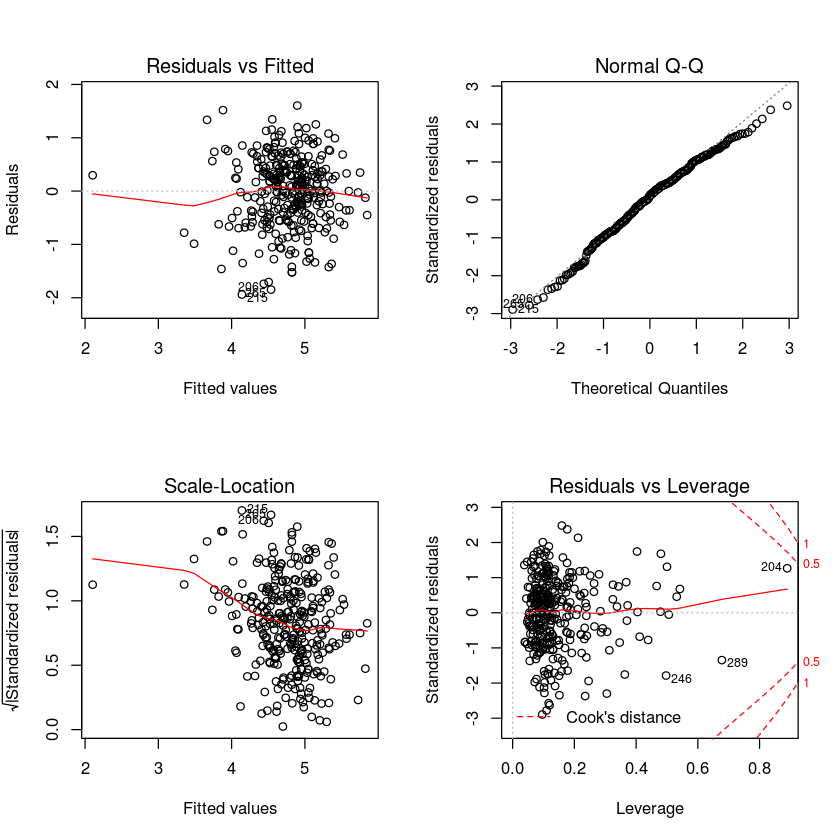

In [10]:
par(mfrow = c(2,2))
plot(baseline)

In [11]:
vif(baseline)[vif(baseline) > 10]

mean.conf.pitch mean.spec.entropy    mean.num.apeak    avg.voiced.seg 
         11.59118          10.30668          11.74448          11.60390

**Adjusted R-squared:** 0.3147. 

It may be a good idea to remove multi-collinear variables before backward selection (based on a p-threshold of < 0.3) as multicollinear variables may lead to inflated p-values.

Here, multicollinear variables are identified as those having a VIF > 10. Those variables are:

- mean.conf.pitch
- mean.spec.entropy
- mean.num.apeak
- avg.voiced.seg

## Model 2
In model 2, we try to reduce multicollinearity as a precursor the backward selection. We do this by removing certain features.

In [12]:
model2 = update(baseline, ~. 
                -mean.spec.entropy 
                -mean.num.apeak 
                -mean.conf.pitch)

We removed **mean.spec.entropy**, **mean.num.apeak**, and **mean.conf.pitch**. Now, no variables have a VIF of higher than 10.

In [16]:
summary(model2)


Call:
lm(formula = Emot ~ gender + mean.pitch + sd.pitch + sd.conf.pitch + 
    sd.spec.entropy + mean.val.apeak + sd.val.apeak + mean.loc.apeak + 
    sd.loc.apeak + sd.num.apeak + mean.energy + sd.energy + mean.d.energy + 
    sd.d.energy + avg.voiced.seg + avg.len.seg + time.speaking + 
    voice.rate + num.turns + hogv.entropy + hogv.median + hogv.cogR + 
    hogv.cogC + words_Extraversion + words_Agreeableness + words_Conscientiousness + 
    words_Neuroticism + words_Openness + words_nExtraversion + 
    words_nAgreeableness + words_nConscientiousness + words_nNeuroticism + 
    words_nOpenness + anger + anticipation + disgust + fear + 
    joy + negative + positive + sadness + surprise + trust + 
    sentiment, data = training_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.02722 -0.46109  0.07849  0.45879  1.59216 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               4.817163   0.072246  66.677  < 2e-16 

## Model 3
In model 3, we integrate **backward selection** by removing features with p-values higher than 0.3.

In [41]:
to_remove = ols_step_backward(model2,prem = 0.3)

We are eliminating variables based on p value...
No more variables satisfy the condition of prem: 0.3


In [42]:
paste(to_remove$removed, collapse = " - ")

[1] "sadness - voice.rate - sd.pitch - sd.energy - disgust - mean.pitch - words_Neuroticism - mean.d.energy - num.turns - anticipation - mean.loc.apeak - words_Extraversion - trust - fear - sd.conf.pitch - sd.loc.apeak - sd.num.apeak - anger - words_nNeuroticism - words_nConscientiousness - words_Openness - words_Conscientiousness - words_nOpenness - avg.len.seg"

In [43]:
model3 = update(model2, ~. -sadness - voice.rate - sd.pitch - sd.energy - disgust - mean.pitch 
                           - words_Neuroticism - mean.d.energy - num.turns - anticipation - mean.loc.apeak 
                           - words_Extraversion - trust - fear - sd.conf.pitch - sd.loc.apeak - sd.num.apeak 
                           - anger - words_nNeuroticism - words_nConscientiousness - words_Openness 
                           - words_Conscientiousness - words_nOpenness - avg.len.seg)

In [44]:
summary(model3)


Call:
lm(formula = Emot ~ gender + sd.spec.entropy + mean.val.apeak + 
    sd.val.apeak + mean.energy + sd.d.energy + avg.voiced.seg + 
    time.speaking + hogv.entropy + hogv.median + hogv.cogR + 
    hogv.cogC + words_Agreeableness + words_nExtraversion + words_nAgreeableness + 
    joy + negative + positive + surprise + sentiment, data = training_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.07535 -0.46281  0.06631  0.46626  1.60252 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           4.82537    0.05772  83.593  < 2e-16 ***
genderMale           -0.10194    0.08845  -1.153  0.25002    
sd.spec.entropy      -0.06191    0.04945  -1.252  0.21150    
mean.val.apeak        0.13397    0.05780   2.318  0.02112 *  
sd.val.apeak          0.15005    0.05617   2.671  0.00797 ** 
mean.energy           0.25082    0.10045   2.497  0.01306 *  
sd.d.energy          -0.25418    0.10252  -2.479  0.01371 *  
avg.voiced.seg        0.09

## Model 4
Remove rows where absolute studentized residual exceeded 3.

In [45]:
outlierTest(model3)

No Studentized residuals with Bonferonni p < 0.05
Largest |rstudent|:
     rstudent unadjusted p-value Bonferonni p
215 -3.137353           0.001873      0.60686

In [46]:
training_data = training_data[-215,]

In [50]:
model4 = update(model2, ~. -sadness - voice.rate - sd.pitch - sd.energy - disgust - mean.pitch 
                           - words_Neuroticism - mean.d.energy - num.turns - anticipation - mean.loc.apeak 
                           - words_Extraversion - trust - fear - sd.conf.pitch - sd.loc.apeak - sd.num.apeak 
                           - anger - words_nNeuroticism - words_nConscientiousness - words_Openness 
                           - words_Conscientiousness - words_nOpenness - avg.len.seg)

In [51]:
summary(model4)


Call:
lm(formula = Emot ~ gender + sd.spec.entropy + mean.val.apeak + 
    sd.val.apeak + mean.energy + sd.d.energy + avg.voiced.seg + 
    time.speaking + hogv.entropy + hogv.median + hogv.cogR + 
    hogv.cogC + words_Agreeableness + words_nExtraversion + words_nAgreeableness + 
    joy + negative + positive + surprise + sentiment, data = training_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.84932 -0.45690  0.07556  0.45549  1.59045 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           4.82582    0.05690  84.812  < 2e-16 ***
genderMale           -0.08926    0.08728  -1.023  0.30728    
sd.spec.entropy      -0.06316    0.04874  -1.296  0.19604    
mean.val.apeak        0.12969    0.05699   2.276  0.02356 *  
sd.val.apeak          0.14189    0.05543   2.560  0.01096 *  
mean.energy           0.24816    0.09902   2.506  0.01273 *  
sd.d.energy          -0.25499    0.10106  -2.523  0.01214 *  
avg.voiced.seg        0.09

## Model 5
Modelling non-linear relationships.

In [53]:
training_data = 
    training_data %>%
    select(Emot, gender, sd.spec.entropy,
          mean.val.apeak,sd.val.apeak,
          mean.energy, sd.d.energy,
          avg.voiced.seg, time.speaking,
          hogv.entropy, hogv.median ,
          hogv.cogR, hogv.cogC ,
          words_Agreeableness, words_nExtraversion,
          words_nAgreeableness, words_nAgreeableness ,
          joy, negative, positive,
          surprise,sentiment)

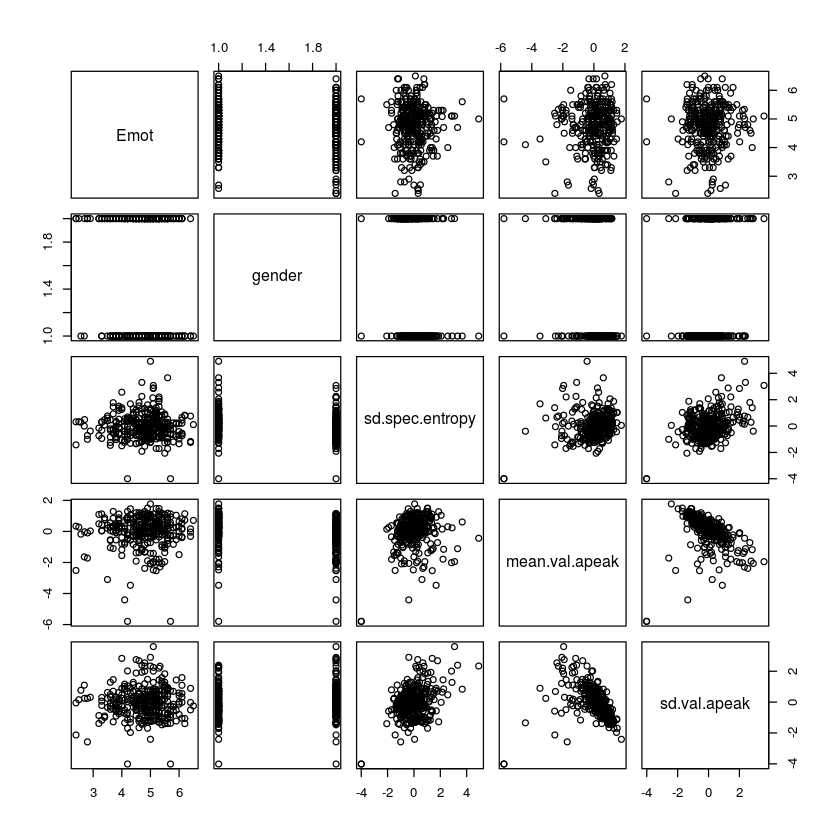

In [56]:
pairs(training_data[,c(1:5)])

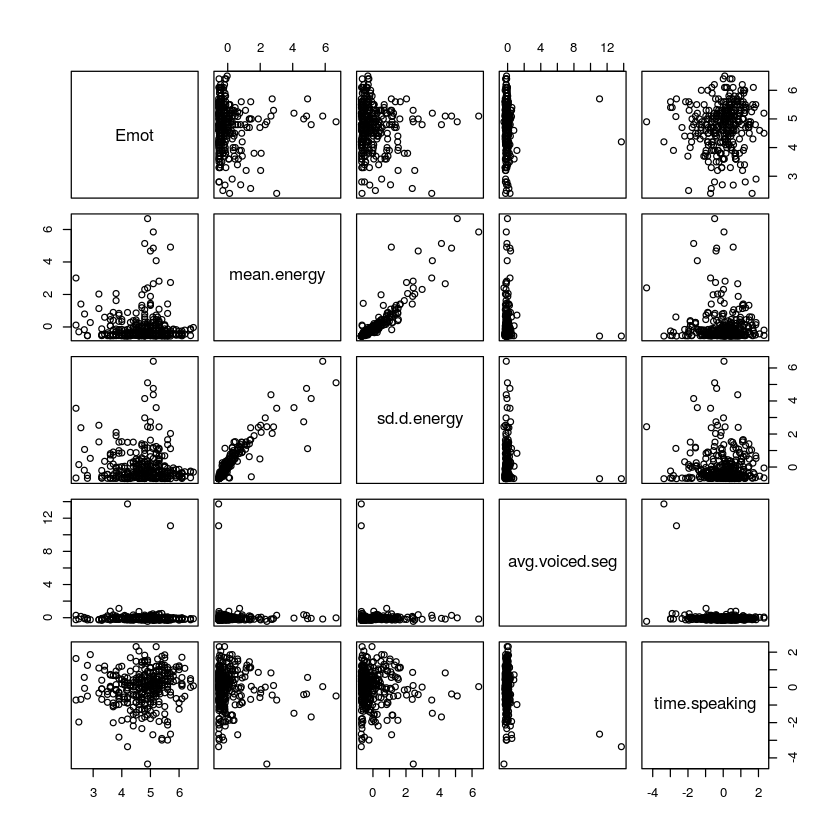

In [57]:
pairs(training_data[,c(1, 6:9)])

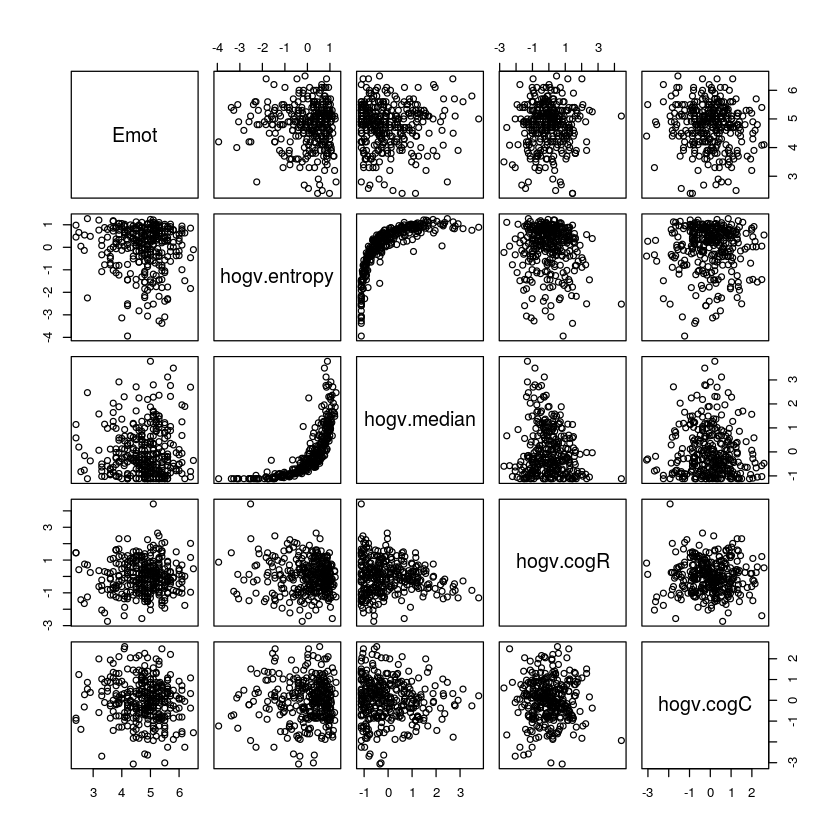

In [58]:
pairs(training_data[,c(1, 10:13)])

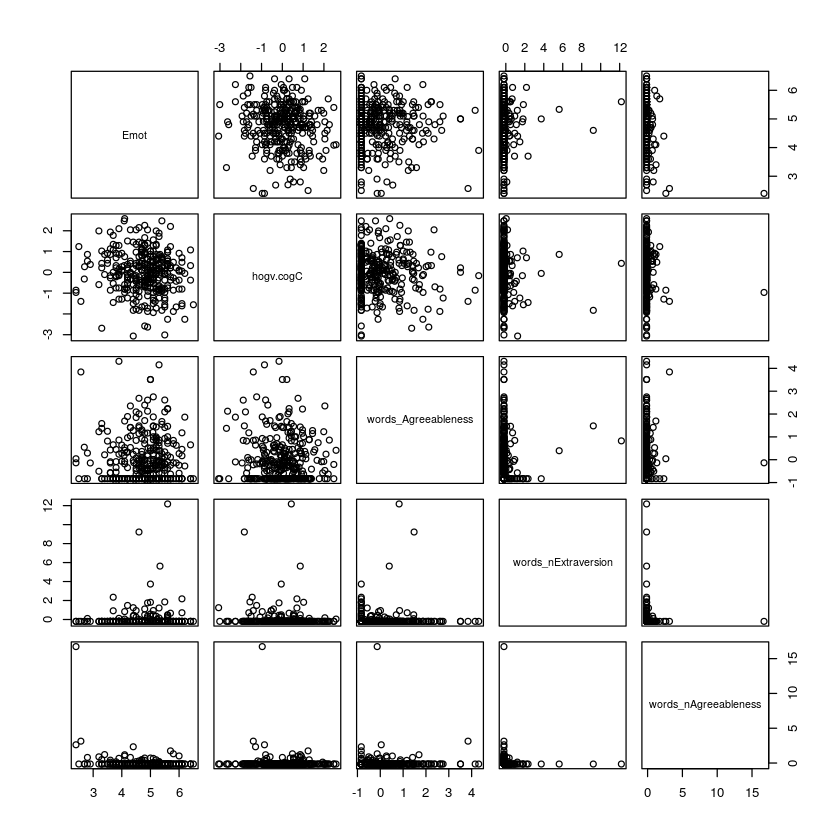

In [59]:
pairs(training_data[,c(1, 13:16)])

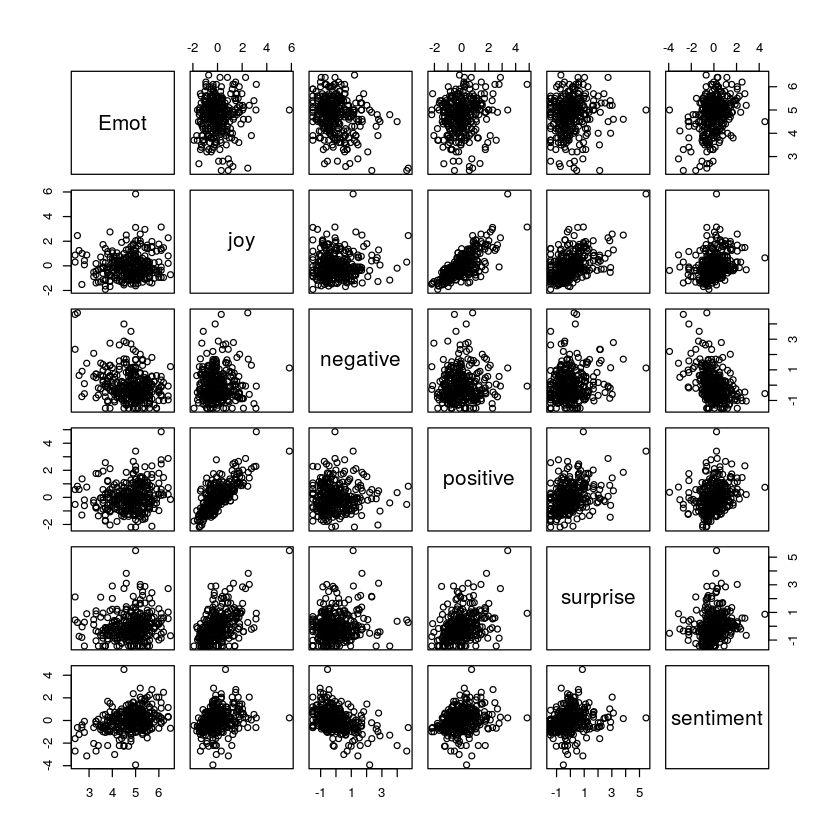

In [65]:
pairs(training_data[,c(1, 17:21)])

No non-linear relationship detected.

## Model 6
Modeling interactions with gender. Beat 0.2172

In [89]:
model6 = update(model4, ~. + gender*words_Agreeableness 
                           + gender*sd.val.apeak 
                           + gender*negative)

In [90]:
summary(model6)


Call:
lm(formula = Emot ~ gender + sd.spec.entropy + mean.val.apeak + 
    sd.val.apeak + mean.energy + sd.d.energy + avg.voiced.seg + 
    time.speaking + hogv.entropy + hogv.median + hogv.cogR + 
    hogv.cogC + words_Agreeableness + words_nExtraversion + words_nAgreeableness + 
    joy + negative + positive + surprise + sentiment + gender:words_Agreeableness + 
    gender:sd.val.apeak + gender:negative, data = training_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.83380 -0.44135  0.06806  0.43276  1.46389 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     4.82479    0.05650  85.398  < 2e-16 ***
genderMale                     -0.09534    0.08619  -1.106  0.26952    
sd.spec.entropy                -0.05975    0.04821  -1.239  0.21622    
mean.val.apeak                  0.11144    0.05666   1.967  0.05011 .  
sd.val.apeak                    0.05710    0.06907   0.827  0.40913    
mean.energy     